#Image Caption Generator Using VIT + GPT2
This file contains only finetuned model. Model testing is done in Transformer_Test.ipynb file

In [ ]:
pip install accelerate -U

#Loading Dataset

In [2]:
import pandas as pd
from pathlib import Path

df = pd.DataFrame(columns=['imgs'])

imgs, captions = [], []

img_folder = "/content/drive/MyDrive/Flickr/Flicker8k_Dataset"

caption_file = "/content/drive/MyDrive/Flickr/Caption_data/Flickr8k.token.txt"


In [3]:
with open(caption_file, "r") as f:
    content = f.read()

In [4]:
datatxt = []
for line in content.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df = pd.DataFrame(datatxt,columns=["filename","index","caption"])

In [5]:
df.head(5)

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...


In [6]:
df = df[df["index"] == "0"].copy()
df['filename'] = img_folder + '/' + df['filename']
df= df.reset_index(drop=True)

In [7]:
df.iloc[0].filename

'/content/drive/MyDrive/Flickr/Flicker8k_Dataset/1000268201_693b08cb0e.jpg'

In [8]:
from PIL import Image
with Image.open(df.iloc[2].filename) as img:
            print(f"{img.size} (width x height)")

(500, 400) (width x height)


#Loading VIt and GPT2 model







In [9]:
from transformers import AutoFeatureExtractor, AutoTokenizer

encoder_checkpoint = "google/vit-base-patch16-224-in21k"
decoder_checkpoint = "gpt2"

feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [10]:
tokenizer.pad_token = tokenizer.eos_token
max_length = 128

In [ ]:
from PIL import Image

# maximum length for the captions
max_length = 128
sample = df.iloc[0]

# sample image
image = Image.open(sample['filename']).convert('RGB')
# sample caption
caption = sample['caption']

# apply feature extractor on the sample image
inputs = feature_extractor(images=image, return_tensors='pt')
# apply tokenizer
outputs = tokenizer(
            caption,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt',
        )

#Converting data to Dataset

In [11]:
from torch.utils.data import Dataset

class LoadDataset(Dataset):
    def __init__(self, df):
        self.images = df['filename'].values
        self.captions = df['caption'].values

    def __getitem__(self, idx):

        inputs = dict()


        image_path = str(self.images[idx])
        image = Image.open(image_path).convert("RGB")
        image = feature_extractor(images=image, return_tensors='pt')


        caption = self.captions[idx]
        labels = tokenizer(
            caption,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt',
        )['input_ids'][0]


        inputs['pixel_values'] = image['pixel_values'].squeeze()
        inputs['labels'] = labels
        return inputs

    def __len__(self):
        return len(self.images)

#Splitting dataset

In [12]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [13]:
train_ds = LoadDataset(train_df)
test_ds = LoadDataset(test_df)

# Loading VisionEncoder Model

In [14]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_checkpoint,
    decoder_checkpoint
)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

In [15]:
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [16]:
#using beam search
num_beams = 4
model.config.num_beams = num_beams

In [17]:
from transformers import Seq2SeqTrainingArguments

# batch size
bs = 8

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/Flickr/trained",
    evaluation_strategy="epoch",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs,
    learning_rate=5e-5,
    weight_decay=0.01,
    num_train_epochs=5,
    save_strategy='epoch',
    report_to='none',
)

In [ ]:
from transformers import Seq2SeqTrainer, default_data_collator

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    data_collator=default_data_collator,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    args=training_args,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.332300,0.258002
2,0.233000,0.249114
3,0.210300,0.250011
4,0.179400,0.255218
5,0.162000,0.262827


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'num_beams': 4}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
Removed shared tensor {'decoder.lm_head.weight'} while savi

TrainOutput(global_step=4045, training_loss=0.2173847780828865, metrics={'train_runtime': 3525.5608, 'train_samples_per_second': 9.179, 'train_steps_per_second': 1.147, 'total_flos': 5.839811516647342e+18, 'train_loss': 0.2173847780828865, 'epoch': 5.0})

#Testing Image

In [ ]:
from transformers import ViTImageProcessor, GPT2TokenizerFast, VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/Flickr/trained1")
feature_extractor = ViTImageProcessor.from_pretrained("/content/drive/MyDrive/Flickr/trained1")
tokenizer       = GPT2TokenizerFast.from_pretrained("/content/drive/MyDrive/Flickr/trained1")

In [ ]:
#test input
inputs = test_ds[11]['pixel_values']

In [ ]:
#Predicting Caption
import torch

model.eval()
with torch.no_grad():


    # generate caption for the image
    out = model.generate(
        inputs.unsqueeze(0).to('cuda'), # move inputs to GPU
        num_beams=num_beams,
        )

# convert token ids to string format
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

print(decoded_out)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1339: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a man and woman sit on a rocky ledge overlooking the water.


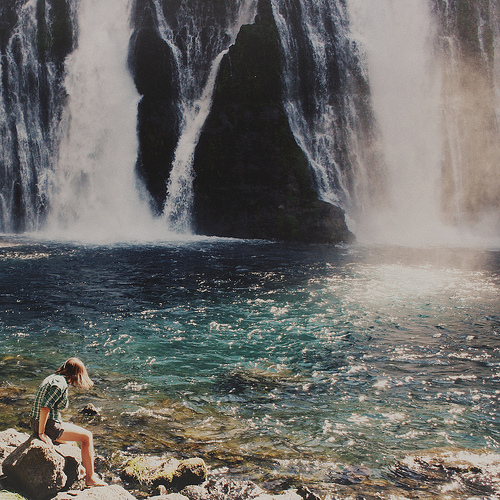

In [ ]:
#Image
Image.open(test_df.iloc[11]['filename'])

In [ ]:
#Original Caption
test_df.iloc[11]['caption']

'a girl is sitting on a rock next to a waterfall .'

#Saving Trained Model and Testing Trained Model Images

In [ ]:

model.save_pretrained("/content/drive/MyDrive/Flickr/trained1")
feature_extractor.save_pretrained("/content/drive/MyDrive/Flickr/trained1")
tokenizer.save_pretrained("/content/drive/MyDrive/Flickr/trained1")


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'num_beams': 4}


('/content/drive/MyDrive/Flickr/trained1/tokenizer_config.json',
 '/content/drive/MyDrive/Flickr/trained1/special_tokens_map.json',
 '/content/drive/MyDrive/Flickr/trained1/vocab.json',
 '/content/drive/MyDrive/Flickr/trained1/merges.txt',
 '/content/drive/MyDrive/Flickr/trained1/added_tokens.json',
 '/content/drive/MyDrive/Flickr/trained1/tokenizer.json')

In [ ]:
#Testing saved model image
inputs = test_ds[12]['pixel_values']

In [ ]:
#Predict Caption
import torch

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

with torch.no_grad():
    inputs = inputs.to(device)

    # Generate caption for the image
    outputs = model.generate(
        inputs.unsqueeze(0),
        num_beams=4,

    )
    caption = tokenizer.decode(outputs[0], skip_special_tokens=True)


    print(caption)


a black and white dog runs through the grass.


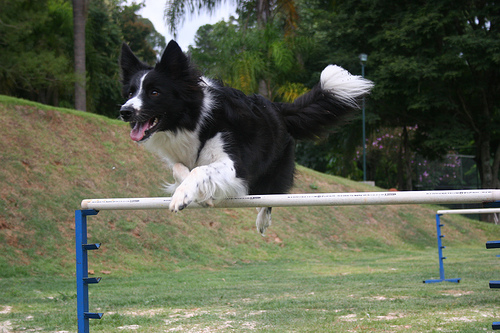

In [ ]:
#Original Image
Image.open(test_df.iloc[12]['filename'])